## Deep learing project no.1

Marek Szydłowski 136633 <br>
Wotjek Tomczak 145467

In [1]:
import os
import fnmatch
import webbrowser
from pathlib import Path

from IPython.display import display

import pandas as pd
import numpy as np
import tensorflow as tf
import cv2

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt


In [2]:
DATA_PATH = "data/101_ObjectCategories/"
DATA_TAR = "data/101_ObjectCategories.tar.gz"

# We don't like Google so we will remove it ~ sent from Google Pixel 5 :)
BACKGROUND_GOOGLE = DATA_PATH + "BACKGROUND_Google"

NO_CLASSES = 20

In [3]:
data_check = Path(DATA_PATH)
tar_check = Path(DATA_TAR)

if not data_check.exists() and not tar_check.exists():
    # No data exists
    _ = webbrowser.open(
        "https://drive.google.com/u/0/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&export=download"
    )

    raise Exception("Please download the data first and place it in data folder and rerun the cell")

elif tar_check.exists():
    # Extract and remove tar.gz file
    !tar -xf $DATA_TAR --directory="data"
    !rm -r $BACKGROUND_GOOGLE
    !rm $DATA_TAR


In [4]:
# cheking size of classes in our database of choice

file_counter = []

for data_dir in Path(DATA_PATH).iterdir():
    file_counter.append(
        [
            len(fnmatch.filter(os.listdir(data_dir), "*.jpg")),
            str(data_dir).split("/")[-1],
        ]
    )

results = pd.DataFrame(
    sorted(file_counter, key=lambda x: x[0], reverse=True),
    columns=["FILE_COUNT", "CLASS_NAME"],
)

results


,FILE_COUNT,CLASS_NAME
0,800,airplanes
1,798,Motorbikes
2,435,Faces_easy
3,435,Faces
4,239,watch
...,...,...
96,34,garfield
97,34,wild_cat
98,33,binocular
99,32,metronome


In [5]:
classes = results[results['FILE_COUNT'] > 86]['CLASS_NAME'].values
max_len = np.min(results[results['FILE_COUNT'] > 86]['FILE_COUNT'])

In [8]:
classes

array(['airplanes', 'Motorbikes', 'Faces_easy', 'Faces', 'watch',
       'Leopards', 'bonsai', 'car_side', 'ketch', 'chandelier',
       'hawksbill', 'grand_piano', 'brain', 'butterfly', 'helicopter',
       'menorah'], dtype=object)

In [9]:
images = {}
for data_dir in Path(DATA_PATH).iterdir():
    if data_dir.name in classes:
        current_len = 0
        for f in data_dir.iterdir():
            if current_len == max_len:
                break

            if not f.is_file():
                continue

            current_len += 1

            if data_dir.name not in images:
                images[data_dir.name] = 1
            else:
                images[data_dir.name] += 1

df = (
    pd.DataFrame.from_dict(images, "index")
    .reset_index()
    .rename({0: "length", "index": "name"}, axis=1)
)

In [10]:
df

,name,length
0,ketch,87
1,chandelier,87
2,menorah,87
3,grand_piano,87
4,Leopards,87
5,Faces_easy,87
6,airplanes,87
7,hawksbill,87
8,Motorbikes,87
9,watch,87


In [18]:
dataset = []
labels = []
filenames = []

for row in df.itertuples():
    dirname = row.name
    max_len = row.length

    current_len = 0
    for filename in os.listdir(DATA_PATH + dirname):
        if current_len == max_len:
            break

        if ".jpg" not in filename:
            continue

        current_len += 1

        img = cv2.imread(DATA_PATH + dirname + "/" + filename)
        resized = cv2.resize(img, (32, 32), interpolation=cv2.INTER_AREA)

        filenames.append(dirname + "/" + filename)
        dataset.append(resized)
        labels.append(dirname)

dataset = np.array(dataset)

In [19]:
dataset.shape

(1392, 32, 32, 3)

In [20]:
bgr_mean = np.mean(dataset, axis=(0, 1, 2))
bgr_std = np.std(dataset, axis=(0, 1, 2))
bgr_mean, bgr_std


(array([127.88420298, 132.71503598, 134.22760992]),
 array([76.2691887 , 72.26450498, 74.61910031]))

In [21]:
std_data = (dataset - bgr_mean) / bgr_std
std_data.shape


(1392, 32, 32, 3)

Image before standardization


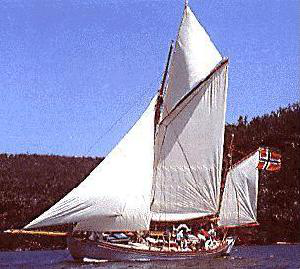

In [22]:
print('Image before standardization')
with Image.open(DATA_PATH + filenames[0]) as img:
    display(img)

In [23]:
# DO NOT CLOSE IMAGE WITH "X" ICON, JUST WAIT
# Uncoment to run


# cv2.imshow('tmp', std_data[0])
# cv2.waitKey(7000)

# cv2.destroyAllWindows()

In [24]:
# splitting data on train and test
X_train, X_test, y_train, y_test = train_test_split(
    std_data, labels, stratify=labels, test_size=0.3, random_state=23
)

y_train, y_test = np.array(y_train), np.array(y_test)


In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((974, 32, 32, 3), (418, 32, 32, 3), (974,), (418,))

In [26]:
def oneHotterEncoder(target):
    _target = target.reshape(-1, 1)
    encoder = OneHotEncoder(handle_unknown="ignore")
    new_target = encoder.fit(_target)
    return new_target.categories_, new_target.transform(_target).toarray()


In [27]:
classes_train, y_train_enc = oneHotterEncoder(y_train)
classes_test, y_test_enc = oneHotterEncoder(y_test)

(classes_train,) = classes_train
(classes_test,) = classes_test


In [41]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=X_train[0].shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(.75))
model.add(layers.Dense(64))
model.add(layers.Dropout(.65))
model.add(layers.Dense(64))
model.add(layers.Dense(len(classes), activation='softmax'))

print(f"Number of classes: {len(classes)}")
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=5)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    X_train,
    y_train_enc,
    batch_size=32,
    epochs=250,
    validation_data=(X_test, y_test_enc),
    callbacks=[early_stopping],
)

Number of classes: 16
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 64)          36928     
                                                                 
 batch_normalization_4 (Batc  (N

14/14 - 0s - loss: 0.6408 - accuracy: 0.8612 - 101ms/epoch - 7ms/step


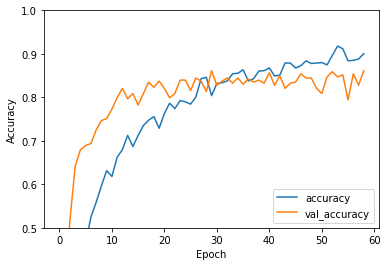

In [42]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test_enc, verbose=2)

In [54]:
print(f'Test accuracy: {round(test_acc * 100, 4)}%')

Test accuracy: 86.1244%
